## ANLP Assignment 1: Sentiment Analysis
### Christopher Hamilton,  a1766121

In [1]:
import json
import os 

import pandas as pd
import numpy as np
from langdetect import detect as detect_language

### 1. Reading dataset and initial pre-processing

In [ ]:
def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            data.append(json.loads(line))    

    return pd.json_normalize(data)

train_df = read_json_to_df("hotel_reviews_train.json")

In [3]:
train_df.head()

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_reviews,author.id,author.location,author.num_cities,author.num_helpful_votes,author.num_type_reviews,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,September 2012,80138,0,"September 19, 2012",140716137,False,1.0,2.0,...,1.0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,June 2011,240151,1,"June 27, 2011",114807323,False,1.0,1.0,...,NaN,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,October 2010,80793,0,"October 25, 2010",84805430,False,4.0,5.0,...,4.0,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0,NaN,NaN
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,June 2012,111418,1,"June 28, 2012",132971117,False,3.0,2.0,...,1.0,JoanellenJ,22.0,BC6BC07F81B768F78B6CE17A18762C11,New York,10.0,9.0,5.0,NaN,NaN
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",January 2012,671150,3,"February 4, 2012",124104157,False,NaN,NaN,...,NaN,Lynnworks,3.0,F7E9D044FA2554FD06A871289312E043,Providence,3.0,7.0,3.0,NaN,NaN


In [4]:
predict_overall_train_df = train_df[["title", "text", "ratings.overall"]]

predict_overall_train_df.head()
predict_overall_train_df["ratings.overall"].value_counts()

ratings.overall
5.0    9825
4.0    7720
3.0    3287
2.0    1611
1.0    1557
Name: count, dtype: int64

In [5]:
predict_overall_train_df.loc[:,'title'] = ["".join(filter(lambda c: str.isalnum(c) or str.isspace(c), char)) for char in predict_overall_train_df.title]
predict_overall_train_df.loc[:,'text'] = ["".join(filter(lambda c: str.isalnum(c) or str.isspace(c), char)) for char in predict_overall_train_df.text]

In [6]:
predict_overall_train_df.head()

,title,text,ratings.overall
0,Horrible experience,First of all we got there and they didnt have ...,1.0
1,Stay Away,Found Racist graffiti in the room Request to c...,1.0
2,Great location and service,Close to Union Square hotel is a bit of a maz...,4.0
3,I will never go back here again,I had a bad vibe about this place from the mom...,2.0
4,Ripped off our VISA card after departure,After we received our final bill and left the ...,1.0


In [7]:
def filter_english_reviews(df):
    def is_english(text):
        try:
            return detect_language(text) == "en"
        except:
            return False

    return df[df['text'].apply(is_english) & df['title'].apply(is_english)]

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Save the English reviews to a CSV file to save time filtering when running again
if os.path.exists("english_hotel_reviews_train.csv"):
    predict_overall_train_df = pd.read_csv("english_hotel_reviews_train.csv")
else:
    predict_overall_train_df = filter_english_reviews(predict_overall_train_df)
    predict_overall_train_df.to_csv("english_hotel_reviews_train.csv", index=False)

In [9]:
predict_overall_train_df.head()

,title,text,ratings.overall
2,Great location and service,Close to Union Square hotel is a bit of a maz...,4.0
3,I will never go back here again,I had a bad vibe about this place from the mom...,2.0
4,Ripped off our VISA card after departure,After we received our final bill and left the ...,1.0
5,A great location,Steps to Grand Central a very well situated ho...,4.0
6,Its all about the Location,This Hotel is located right in the heart of Sa...,3.0


In [10]:
print(train_df.info())
print(predict_overall_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   title                                           24000 non-null  object 
 1   text                                            24000 non-null  object 
 2   date_stayed                                     23050 non-null  object 
 3   offering_id                                     24000 non-null  int64  
 4   num_helpful_votes                               24000 non-null  int64  
 5   date                                            24000 non-null  object 
 6   id                                              24000 non-null  int64  
 7   via_mobile                                      24000 non-null  bool   
 8   ratings.service                                 21550 non-null  float64
 9   ratings.cleanliness                    

### 2. Exploratory Data Analysis (EDA)

In [13]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/dev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

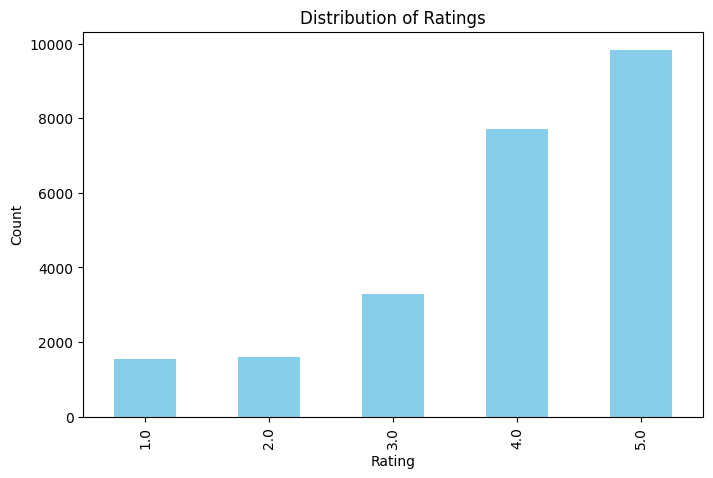

In [14]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Remove common words
X = vectorizer.fit_transform(train_df["text"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

correlations = tfidf_df.corrwith(train_df["ratings.overall"])
correlations = correlations.sort_values(ascending=False)  # Sort by importance

# Find words with the weakest correlation (near zero)
non_predictive_words = correlations.sort_values(key=lambda x: np.abs(x))
print("Non-Predictive Words:\n", non_predictive_words.head(10))

# Display top positive and negative correlated words
print("Most Positive Words:\n", correlations.head(10))
print("\nMost Negative Words:\n", correlations.tail(10))

Non-Predictive Words:
 jane         0.000003
familiar     0.000005
teenagers    0.000028
39          -0.000029
extend      -0.000033
couches      0.000035
doughnuts   -0.000042
bldg        -0.000043
queue        0.000045
keeping      0.000047
dtype: float64
Most Positive Words:
 great          0.251586
staff          0.196470
friendly       0.167828
comfortable    0.159558
helpful        0.156769
wonderful      0.153227
excellent      0.148437
perfect        0.147401
highly         0.132126
loved          0.126517
dtype: float64

Most Negative Words:
 carpet     -0.153744
bad        -0.155436
room       -0.156964
horrible   -0.164654
terrible   -0.168106
rude       -0.182339
said       -0.185605
worst      -0.212137
dirty      -0.233399
told       -0.250588
dtype: float64


In [16]:
# Split all reviews into words and find unique ones
all_words_text = predict_overall_train_df.text.apply(nltk.word_tokenize)
all_words_title = predict_overall_train_df.title.apply(nltk.word_tokenize)

all_words = pd.concat([all_words_text, all_words_title])
unique_words = np.unique(all_words)

print("Total Unique Words:", len(unique_words))


Total Unique Words: 35780


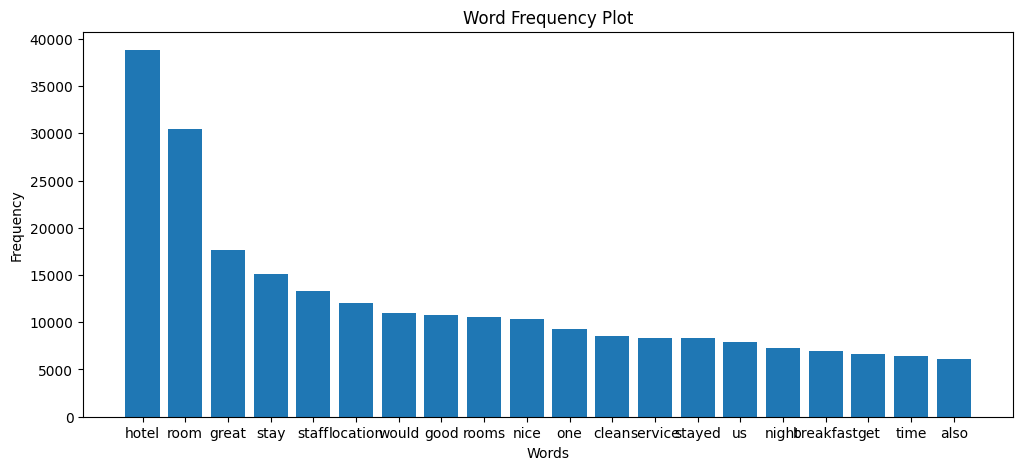

In [17]:
# Word frequency plots are used to visualize the most common words in a dataset.

from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokens = [
    word.lower() for sentence in unique_words.tolist()
    for s in sentence
    for word in word_tokenize(s)
    if word.isalnum() and word.lower() not in stop_words
]

word_freq = Counter(tokens)

plt.figure(figsize=(12, 5))
plt.bar(*zip(*word_freq.most_common(20)))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Plot")
plt.show()


Distribution of 3-grams:
within walking distance: 788
front desk staff: 696
hotel great location: 593
staff friendly helpful: 584
would definitely stay: 559
would recommend hotel: 313
great place stay: 306
empire state building: 289
flat screen tv: 288
stayed one night: 270
would highly recommend: 267
highly recommend hotel: 256
new york city: 252
great location great: 234
called front desk: 211
right across street: 205
recommend hotel anyone: 197
hotel good location: 181
would definitely recommend: 180
easy walking distance: 162
great hotel great: 153
stayed 3 nights: 151
king size bed: 140
hotel staff friendly: 140
stayed two nights: 135
walk times square: 132
staff great location: 130
right next door: 129
front desk clerk: 127
stayed 4 nights: 127
location great hotel: 125
room clean comfortable: 125
really enjoyed stay: 122
stayed 2 nights: 121
friendly helpful staff: 118
made us feel: 117
staff helpful friendly: 112
grand central station: 111
clean staff friendly: 110
two double b

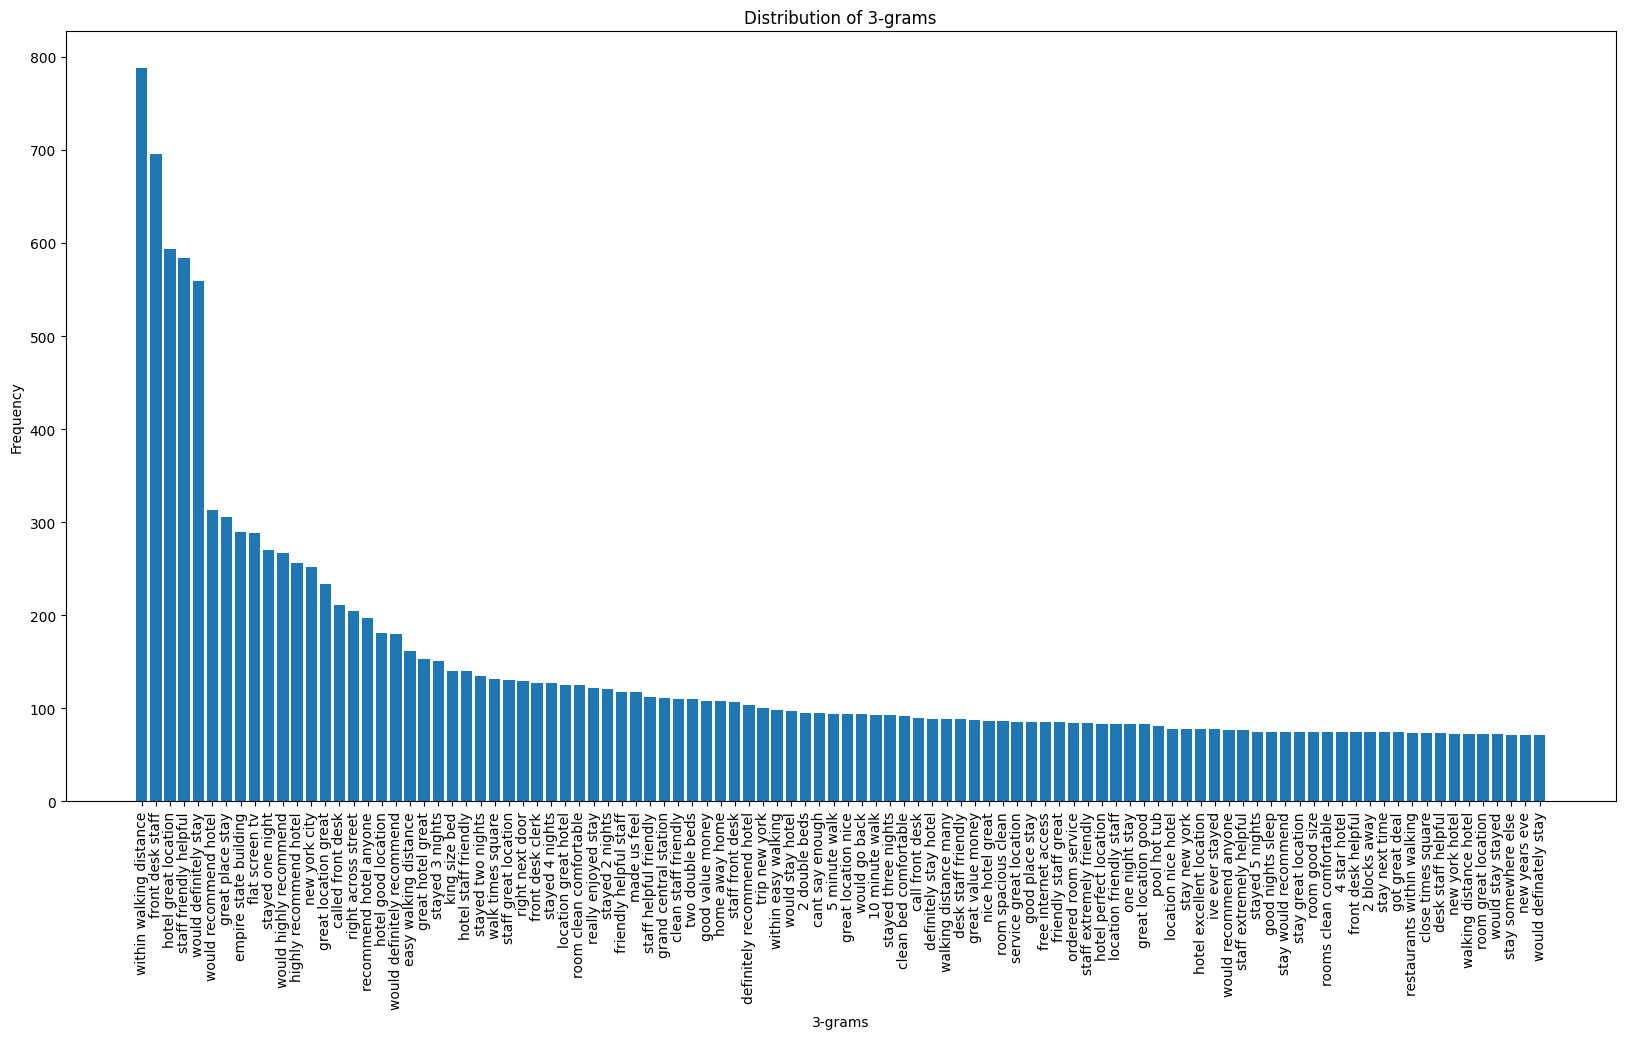

In [26]:
# Identifying common N-grams: N-grams are sequences of words. 
# Identifying common n-grams can give insight into the most common phrases in the dataset.

from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 3  # You can change this value to see different n-grams, e.g., 2 for bigrams, 3 for trigrams, etc.

# Generate n-grams
ngrams_list = generate_ngrams(tokens, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)
most_common_ngrams = ngrams_count.most_common(100)

# Display the distribution
print(f"Distribution of {n_value}-grams:")
for ngram, count in most_common_ngrams:
    print(f"{ngram}: {count}")

# Plot the distribution
labels, values = zip(*most_common_ngrams)
indexes = range(len(labels))

plt.figure(figsize=(20, 10))
plt.bar(indexes, values)
plt.xlabel(f'{n_value}-grams')
plt.ylabel('Frequency')
plt.xticks(indexes, labels, rotation='vertical')
plt.title(f'Distribution of {n_value}-grams')
plt.show()

### 3. Selection and training Machine Learning models

In [27]:
from sklearn.model_selection import train_test_split

X_res = pd.concat([predict_overall_train_df["title"], predict_overall_train_df["text"]], axis=1)
X_res = X_res["title"] + " " + X_res["text"]
y_res = predict_overall_train_df["ratings.overall"]

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, shuffle=True)


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [29]:
result_dict_train = {}
result_dict_test = {}


In [30]:
from sklearn.model_selection import cross_val_score


#### Multinomial Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB

# https://www.geeksforgeeks.org/multinomial-naive-bayes/

classifier = MultinomialNB()

In [32]:
nb_accuracies = cross_val_score(classifier, X_train_vectors, y_train, cv=5)
classifier.fit(X_train_vectors, y_train)
print("Naive Bayes Train Score:", np.mean(nb_accuracies))
result_dict_train["Naive Bayes Default Train Score"] = np.mean(nb_accuracies)

Naive Bayes Train Score: 0.5867813433149683


In [33]:
naive_bayes_score = classifier.score(X_test_vectors, y_test)
print("Naive Bayes Test Score:", naive_bayes_score)
result_dict_test["Naive Bayes Default Test Score"] = naive_bayes_score


Naive Bayes Test Score: 0.5826381647549531


#### SVM

from sklearn.svm import SVC

classifier = SVC()

svc_accuracies = cross_val_score(classifier, X_train_vectors, y_train, cv=5)
classifier.fit(X_train_vectors, y_train)
print("SVM Train Score:", np.mean(svc_accuracies))
result_dict_train["SVM Default Train Score"] = np.mean(svc_accuracies)

svc_score = classifier.score(X_test_vectors, y_test)
print("SVM Test Score:", svc_score)
result_dict_test["SVM Default Test Score"] = svc_score


In [34]:
import tensorflow as tf

# Limit GPU memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=(6 * 1024))])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2025-03-29 10:48:24.919416: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 10:48:26.137177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743207506.530871   10386 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743207506.635367   10386 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743207507.451535   10386 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1743207514.711960   10386 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
from tensorflow.keras import regularizers

subset_size = 5000  # X_train_vectors.shape[0]

from tensorflow.keras.utils import to_categorical
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1  

y_train_cat = to_categorical(y_train_adjusted, num_classes=5)
y_test_cat = to_categorical(y_test_adjusted, num_classes=5)

X_train_subset = X_train_vectors[:subset_size]
y_train_subset = y_train_cat[:subset_size]
X_val_subset = X_test_vectors[:subset_size]
y_val_subset = y_test_cat[:subset_size]

X_train_tfidf = X_train_subset.toarray()
X_val_tfidf = X_val_subset.toarray()

# Define the model with L2 regularization and increased dropout
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train_tfidf.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer with L2 regularization
    tf.keras.layers.Dropout(0.6),  # Increased dropout for regularization
    tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.01))  # Output layer with L2 regularization
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tfidf, y_train_subset)).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tfidf, y_val_subset)).batch(8).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)


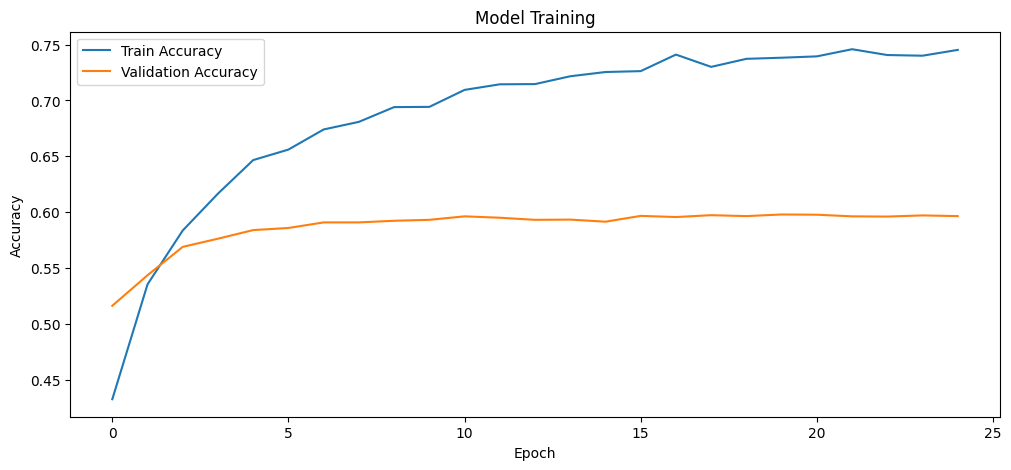

In [12]:
from matplotlib import pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Training')
plt.legend()
plt.show()

In [13]:
# Convert sparse matrices to dense matrices
X_train_tfidf = X_train_vectors.toarray()
X_val_tfidf = X_test_vectors.toarray()

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tfidf, y_train)).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tfidf, y_test)).batch(8).prefetch(tf.data.AUTOTUNE)
# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)


2025-03-28 17:38:29.672884: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.76GiB (rounded to 7263744000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-03-28 17:38:29.672919: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-03-28 17:38:29.672930: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 18, Chunks in use: 18. 4.5KiB allocated for chunks. 4.5KiB in use in bin. 608B client-requested in use in bin.
2025-03-28 17:38:29.672937: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 512B client-requested in use in bin.
2025-03-28 17:38:

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

#### LSTM

In [ ]:
from tensorflow.keras import layers, optimizers, models

vocabulary_size = len(tokenizer.word_counts)

def create_rnn_lstm():
    model = layers.Sequential()
    model.add(layers.Embedding(vocabulary_size, 25, input_length=seq_len))
    model.add(layers.LSTM(150, return_sequences=True))
    model.add(layers.LSTM(150))
    model.add(layers.Dense(150, activation='relu'))

    model.add(layers.Dense(vocabulary_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    model.summary()
    
    return model

classifier = create_rnn_lstm()

classifier.fit(X_train_vectors, y_train, epochs=5)

In [ ]:
print(result_dict_train)
print(result_dict_test)

### 4. Experiment with VADER sentiment lexicon

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

https://pandas.pydata.org/pandas-docs/version/1.2.0/reference/api/pandas.json_normalize.html

https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/

https://pawarbi.github.io/blog/pandas/numpy/data-cleaning/2021/03/05/removing-non-alphanumeric-symbols-characters-from-column-numpy-pandas-dataframe.html


### Appendix